# Plot for dynamic contact angle
For the dynamic contact angle plot in section 3.2.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

if not os.path.isdir('Figures'):
        os.mkdir('Figures')

# pysical properties of water at 20°C
rho_water = 998 # water density in kg/m3
mu_water = 0.00100036 # dynamic viscosity in Pa*s
sigma_air_water = 72.74e-3

mu = mu_water
sigma = sigma_air_water
theta_e = 93/180*np.pi

cos = np.cos
tanh = np.tanh
arccos = np.arccos
arcsinh = np.arcsinh

# Function to calculate the capillary number of contact line
def cal_caCL(uCL, mu, sigma):
    caCL = mu * uCL / sigma
    return caCL

# Function to calculate dynamic contact angle with MKT at 22°C
def cal_theta_MKT(uCL, mu, sigma, theta_e, lamda, kappa0):
    caCL =  uCL * mu / sigma
    cos_theta_MKT = cos(theta_e) - 2*1.380649e-23*295.15 / (sigma*lamda**2) * arcsinh(uCL/(2*kappa0*lamda))
    theta_MKT = arccos(cos_theta_MKT)
    theta_MKT = np.degrees(theta_MKT)
    return theta_MKT

# Function to apply curve-fitting on the experimental data
#def MKT_opt(uCL, lamda, kappa0):
#    return (arccos(cos(theta_e) - 2*1.380649e-23*295.15 / (sigma*lamda**2) * arcsinh(uCL/(2*kappa0*lamda))))

def MKT_opt(uCL, theta_e, lamda, kappa0):
    return (arccos(cos(theta_e) - 2*1.380649e-23*295.15 / (sigma*lamda**2) * arcsinh(uCL/(2*kappa0*lamda))))

## Apply curve-fitting on the contact angle measurements

In [4]:
# Read data
df = pd.read_csv('Data/Data_contact_angle_raw.csv')

# Static contact angle
#theta_e = 88/180*np.pi

# Apply curve-fitting
#popt_MKT, pcov = curve_fit(MKT_opt, df.mean_velocity.values, df.theta_mean.values/180*np.pi, p0=[1e-09, 1e+06]) #input: function, xdata, ydata, startValues
popt_MKT, pcov = curve_fit(MKT_opt, df.mean_velocity.values, df.theta_mean.values/180*np.pi, p0=[88/180*np.pi, 1e-09, 1e+06])
lamda_error = (np.sqrt(pcov[0,0]))
kappa0_error = (np.sqrt(pcov[1,1]))

print("MKT: lambda and kappa0", popt_MKT)
print(lamda_error, kappa0_error)

MKT: lambda and kappa0 [9.98426375e-01 1.10105584e-09 4.35649512e+02]
667.4856636088899 5.32949711119489e-12


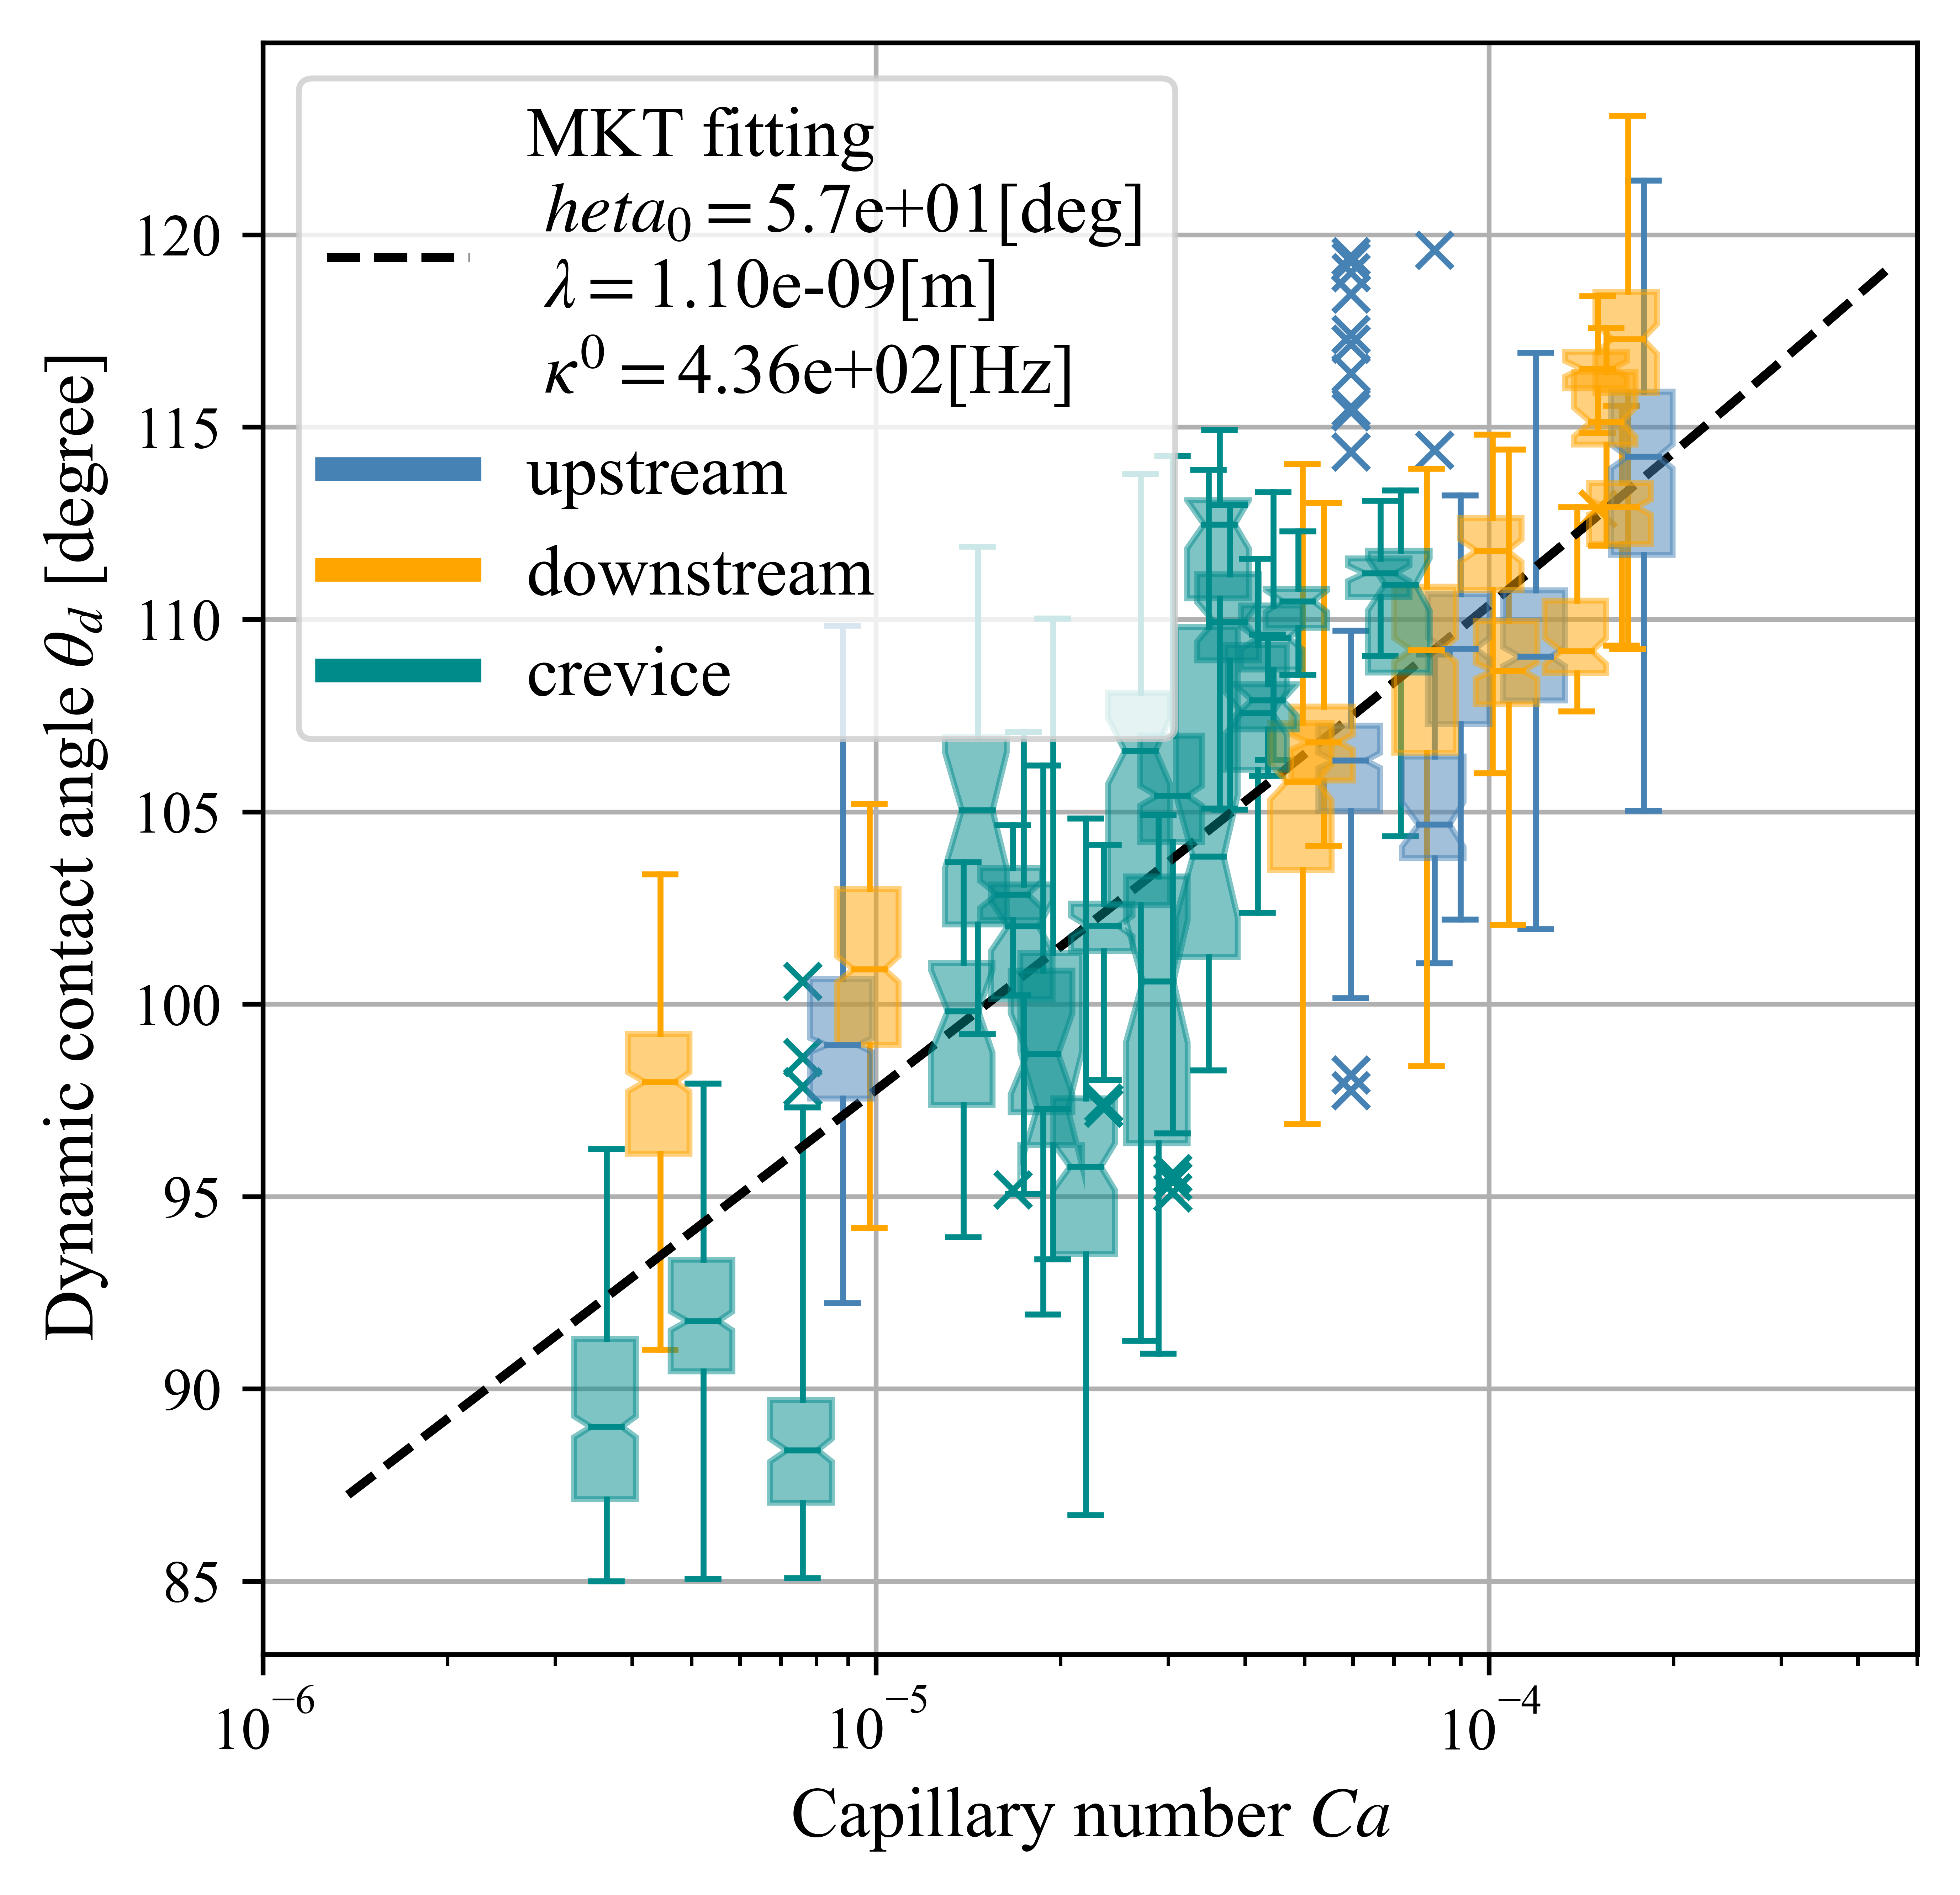

In [5]:
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=1200)
fontsize = 12
labels = ['upstream', 'downstream', 'crevice']
colors = ['steelblue', 'orange', 'darkcyan']

# Prepare data
df1 = df[df['ROI'] == 'before']
df2 = df[df['ROI'] == 'after']
df3 = df[df['ROI'] == 'crevice']
dfs = [df1, df2, df3]

# Create box plot
for i in range(len(dfs)):
    df = dfs[i]
    grouped_data = [df[df['ca'] == ca]['theta_mean'].values for ca in df['ca'].unique()]
    positions = sorted(df['ca'].unique())
    w = 0.1
    width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
    medianprops = dict(linestyle='-', linewidth=2.5, color=colors[i])
    bplot = plt.boxplot(grouped_data, positions=positions, widths=width(positions,w), 
                        medianprops=medianprops, notch=True, 
                        patch_artist=True, showfliers=True, whis=3)

    # Customize box colors and outliers
    for box in bplot['boxes']:
        box.set(color=colors[i], linewidth=1)
        box.set(facecolor = colors[i], alpha=0.5)
    for whisker in bplot['whiskers']:
        whisker.set(color=colors[i], linewidth=1)
    for cap in bplot['caps']:
        cap.set(color=colors[i], linewidth=1)
    for median in bplot['medians']:
        median.set(color=colors[i], linewidth=1)
    for flier in bplot['fliers']:
        flier.set(markeredgecolor=colors[i], linewidth=1)
        flier.set(marker='x', linewidth=1)
    
# Plot MKT contact angles
uCL = np.linspace(0.0001, 0.033, 1000)
caCL = cal_caCL(uCL, mu, sigma)
#plt.plot(caCL, cal_theta_MKT(uCL, mu, sigma, theta_e, popt_MKT[0], popt_MKT[1]), 
#             label= f"MKT fitting \n $\lambda=${popt_MKT[0]:.2e}[m] \n $\kappa^0=${popt_MKT[1]:.2e}[Hz]", color='k', linestyle='--')

plt.plot(caCL, cal_theta_MKT(uCL, mu, sigma, popt_MKT[0], popt_MKT[1], popt_MKT[2]), 
             label= f"MKT fitting \n $\theta_0=${popt_MKT[0]*180/np.pi:.1e}[deg] \n $\lambda=${popt_MKT[1]:.2e}[m] \n $\kappa^0=${popt_MKT[2]:.2e}[Hz]", color='k', linestyle='--')

# Create legends
for j in range(len(labels)):
    plt.plot([], [], color=colors[j], label=labels[j], linewidth=4)

plt.xscale('log')
plt.xlim([1e-6, 5e-4])
plt.grid()
plt.xlabel('Capillary number $Ca$', fontsize=fontsize)
plt.ylabel(r'Dynamic contact angle $\theta_d$ [degree]', fontsize=fontsize)
plt.legend(fontsize=fontsize)
#plt.savefig("Figures/boxPlot.jpg", dpi=1200, bbox_inches="tight")